In [1]:
import numpy as np 
from keras.applications import VGG16
import pandas as pd 
import os
import matplotlib.pyplot as plt 

import matplotlib.image as mimg
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
import import_ipynb
from handcrafted_descriptors.gabor_classification import utility
import tensorflow as tf 
from keras import layers 
from keras import models 
from keras import optimizers 
from sklearn.preprocessing import LabelEncoder 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
import import_ipynb
import define_svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC

Using TensorFlow backend.


importing Jupyter notebook from /Users/admin/Desktop/tesi/Thesis/handcrafted_descriptors/gabor_classification/utility.ipynb
importing Jupyter notebook from define_svm.ipynb


In [2]:
def feature_extraction(directory, sample_count):
    features = np.zeros(shape = (sample_count,3,3,512))
    labels_dummy = np.zeros(shape = (sample_count,20))
    labels =np.zeros(shape = (sample_count,1))
    
    generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory, target_size = (100, 100), 
                                                                            batch_size = batch_size, class_mode = 'categorical')
    
    i = 0   
    print('enter in loop')  
    for input_batch, labels_batch in generator:
        
        features_batch = conv_base.predict(input_batch)
        features[i*batch_size : (i + 1)*batch_size] = features_batch 
        labels_dummy[i*batch_size : (i + 1)*batch_size] = labels_batch
        i = i + 1      
        if i*batch_size >= sample_count:
            break
    return features, labels_dummy


In [3]:
# create labels vector 
def from_dummy_to_labels(dummy_vec):
    res = np.zeros(dummy_vec.shape[0])
    for i in range(dummy_vec.shape[0]):
        tmp = list(dummy_vec[i])
        res[i] = tmp.index(1)
    return res

# ********************** MAIN *************************

In [10]:
species_pth = '../../../data/train'
species = os.listdir(species_pth)

In [11]:
# create dataframe with species and it's path for the image patch!
lichens =[]
for sp in species:
    dr = os.path.join(os.path.join(species_pth, sp))
    al_img = os.listdir(dr)
    
    for imgs in al_img:
        img_dir = os.path.join(dr,imgs)
        lichens.append((sp, img_dir))

        
# create dataframe
lichens_dataframe =pd.DataFrame(data = lichens, columns = ['category', 'image'],index = None)

In [12]:
print("Total number of lichens patch in the dataset: ", len(lichens))
fl_count = lichens_dataframe['category'].value_counts()
print("lichens patch in each category: ")
print(fl_count)

Total number of lichens patch in the dataset:  1121
lichens patch in each category: 
Lecanora_chlarotera           72
Caloplaca_cerina              69
Ramalina_farinacea            60
Physconia_grisea              60
Lecanora_argentata            60
Ramalina_fastigiata           60
Melanelixia_glabratula        60
Physcia_biziana               60
Phaeophyscia_orbicularis      60
Arthonia_radiata              56
Xanthomendoza_fallax          55
Chrysothrix_candelaris        55
Candelariella_reflexa         54
Xanthomendoza_fulva           53
Flavoparmelia_caperata        52
Candelariella_xanthostigma    51
Lecidella_elaeochroma         48
flavoparmenia_soredians       48
Hyperphyscia_adglutinata      45
Gyalolechia_flavorubescens    43
Name: category, dtype: int64


80


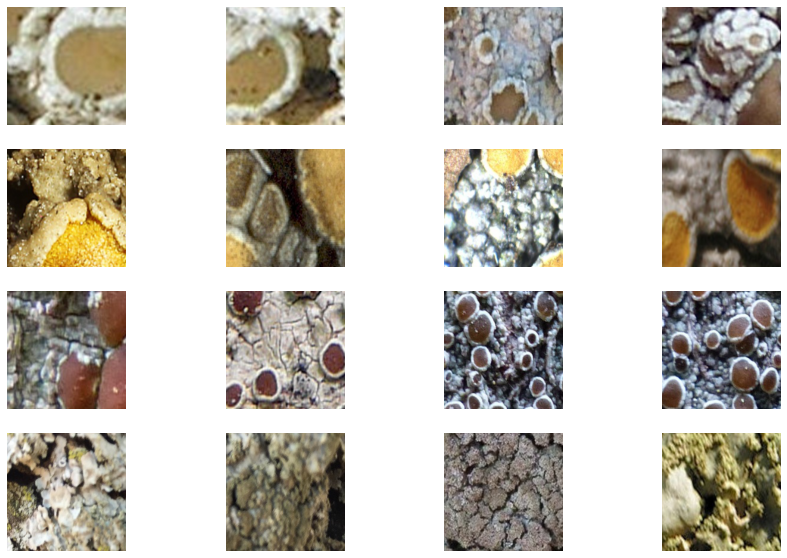

In [11]:
# Let's visualize some lichen's crops from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = lichens_dataframe['image'][lichens_dataframe['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)
print(len(random_samples))
        
# Plot the samples
f, ax = plt.subplots(4,4, figsize=(15,10))
for i,sample in enumerate(random_samples[:16]):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

# USING PRE-TRAINED CONVNET

In [14]:
batch_size = 32
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (100, 100, 3))

# FEATURE EXTRACTION 

We can extract features of our images dataset using a pretrained model. This is called Feature Extraction. There are 2 ways to use this method, first one doesn't support data augmentation, but however the second method is usable with data augmentation.

## NO DATA AUGMENTATION

In [15]:
# write a function which extracts features, and then train an SVM or another neural network
current_dir_train = '../../../data_2/train'
current_dir_val = '../../../data_2/valid'
train_features, train_labels_dummy = feature_extraction(current_dir_train, 1200)   
validation_features, validation_labels_dummy = feature_extraction(current_dir_val, 400)       

Found 1200 images belonging to 20 classes.
enter in loop
Found 400 images belonging to 20 classes.
enter in loop


In [16]:
training_labels = from_dummy_to_labels(train_labels_dummy)
validation_labels = from_dummy_to_labels(validation_labels_dummy)
train_features = np.reshape(train_features, (1200, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (400, 3 * 3 * 512))

## TRAIN A SVM MODEL  WITH EXTRACTED FEATURES!

In [20]:
svc, _ , _ = define_svm.define_and_train_svm(train_features, training_labels, 'linear')
svc.score(validation_features,validation_labels)

here


0.705

In [18]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


0.72
precision:  0.7294249694599594
recall:  0.7231249999999998


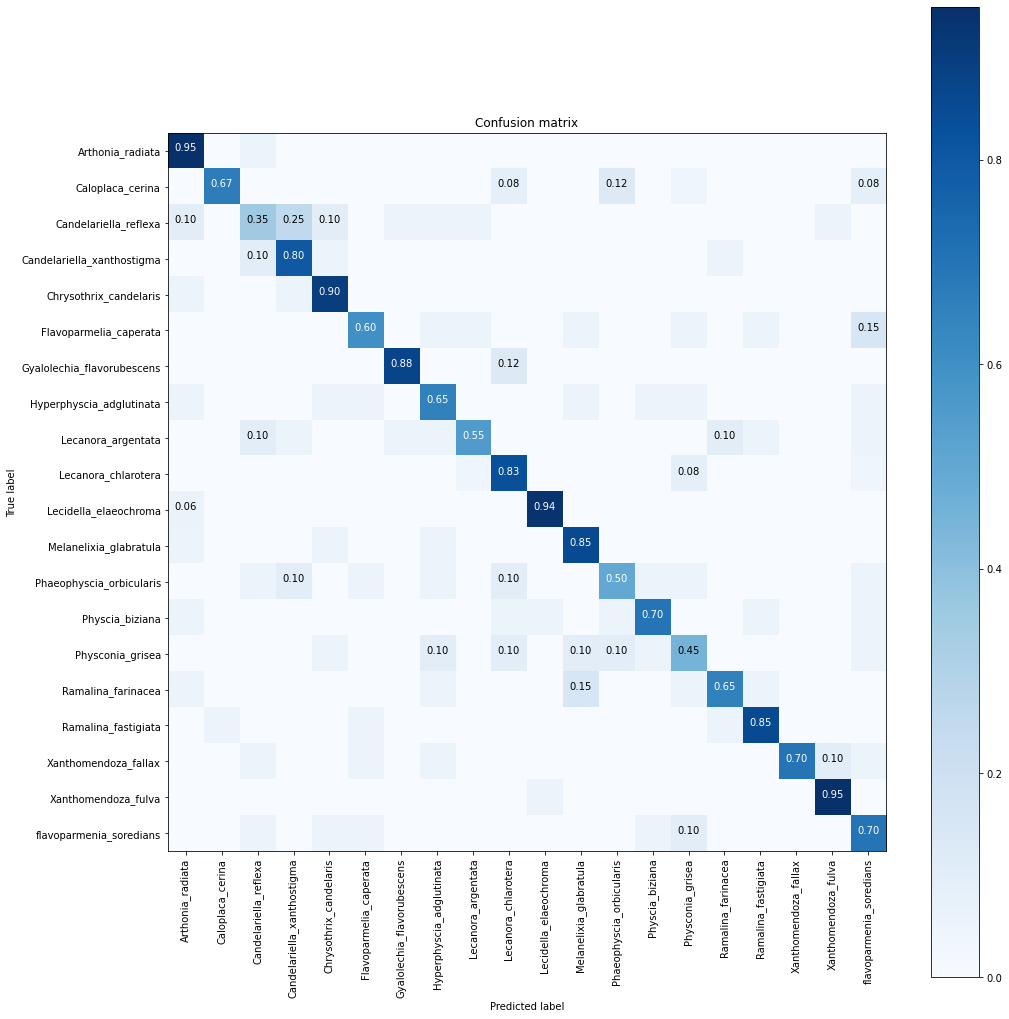

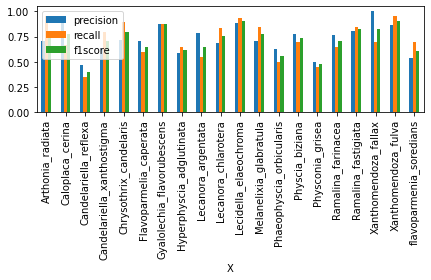

In [23]:
svc  = OneVsRestClassifier(SVC(kernel = 'poly',gamma = 'scale', degree = 10),n_jobs = -1)
svc = svc.fit(train_features, training_labels)
print(svc.score(validation_features,validation_labels))
prd = utility.create_and_save_confusion_matrix(svc, validation_features,validation_labels, species,'results/', 'POLY8' )
a,b,c = utility.calculate_and_plot_precision_recall(validation_labels, prd, species, 'results/', 'pra_poly8')
print('precision: ',a)
print('recall: ',b)

In [ ]:
# linear 0.61
# rbf 0.56
# 2 0.5657 0.598 0.5741
# 3 0.5789 0.6029 0.5893
# 4 0.5921 0.6151 0.6027
# 5 0.603 0.627 0.614
# 6 0.6206 0.647 0.630
# 7 0.627 0.6483 0.6373
# 8 0.6337 0.6523 0.6442
# 9 0.6447  0.6658 0.655
# 10 0.6425 0.6673 0.6542